# Bert Classifier

## Before You Run

### Install Required Libraries

In [1]:
!pip install -q transformers

! pip install hazm

### Import Required Libraries

In [2]:
from transformers import BertConfig, BertTokenizer
from transformers import BertModel

from transformers import AdamW
from transformers import get_linear_schedule_with_warmup

import torch
import torch.nn as nn
import torch.nn.functional as F

import os

from hazm import word_tokenize, Normalizer
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import re
import numpy as np
import collections

### Read Data

In [3]:
PATH = 'data/'
PATH = PATH.rstrip('/')

# Train
df_train = pd.read_csv(PATH + '/train.csv')
df_train.columns = ['index', 'comment', 'rate']

# Evaluation
df_eval = pd.read_csv(PATH + '/eval.csv')
df_eval.columns = ['index', 'comment', 'rate']

# Test
df_test = pd.read_csv(PATH + '/test.csv')
df_test.columns = ['index', 'comment', 'rate']

# Create Lables
label_encoder = LabelEncoder()

train_y = label_encoder.fit_transform((df_train['rate'] >= 0).astype(int))
eval_y = label_encoder.fit_transform((df_eval['rate'] >= 0).astype(int))
test_y = label_encoder.fit_transform((df_test['rate'] >= 0).astype(int))

### Model General Config

In [4]:
# Model Config
MAX_LEN = 128
TRAIN_BATCH_SIZE = 32
VALID_BATCH_SIZE = 32
TEST_BATCH_SIZE = 16

EPOCHS = 10
# Every EEVERY_EPOCH print status
EEVERY_EPOCH = 10
LEARNING_RATE = 2e-5
CLIP = 0.0

MODEL_NAME_OR_PATH = 'HooshvareLab/bert-fa-base-uncased'

## Pre-Trained Bert Tokenizer

### BERT Tokenizer

In [5]:
# setup the tokenizer and configuration

tokenizer = BertTokenizer.from_pretrained(MODEL_NAME_OR_PATH, return_dict=False)
config = BertConfig.from_pretrained(MODEL_NAME_OR_PATH)

### Sample

In [6]:
sample = 'از این محصول بدم اومده!'

In [7]:
tokens = tokenizer.tokenize(sample)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f'Tokens: {tokenizer.convert_tokens_to_string(tokens)}')
print(f'Token IDs: {token_ids}')

Tokens: از این محصول بدم اومده !
Token IDs: [2791, 2802, 3573, 19910, 36711, 1001]


In [8]:
encoding = tokenizer.encode_plus(
    sample,
    max_length=32,
    truncation=True,
    add_special_tokens=True,
    return_token_type_ids=True,
    return_attention_mask=True,
    padding='max_length',
    return_tensors='pt'
)

print(f'Keys: {encoding.keys()}\n')
for k in encoding.keys():
    print(f'{k}:\n{encoding[k]}')

Keys: dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

input_ids:
tensor([[    2,  2791,  2802,  3573, 19910, 36711,  1001,     4,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0]])
token_type_ids:
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])
attention_mask:
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])


## Create Torch Dataset

### Load Torch Dataset

In [9]:
class SentimentDataset(torch.utils.data.Dataset):
    """ Create a PyTorch dataset for Digikala SentimentDataset. """

    def __init__(self, tokenizer, comments, targets, is_predict=False, max_len=128):
        self.comments = comments
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.is_predict = is_predict

    def __len__(self):
        return len(self.comments)

    def __getitem__(self, item):
        comment = str(self.comments[item])

        encoding = self.tokenizer.encode_plus(
            comment,
            add_special_tokens=True,
            truncation=True,
            max_length=self.max_len,
            return_token_type_ids=True,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt')
        
        inputs = {}
        
        inputs = {
            'comment': comment,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'token_type_ids': encoding['token_type_ids'].flatten(),
        }

        if not self.is_predict:
            inputs['targets'] = torch.tensor(self.targets[item], dtype=torch.long)

        return inputs

In [10]:
def create_data_loader(x, y, tokenizer, max_len, batch_size, is_predict=False):
    dataset = SentimentDataset(
        comments=x,
        targets=y,
        tokenizer=tokenizer,
        max_len=max_len,
        is_predict=is_predict)
    
    return torch.utils.data.DataLoader(dataset, batch_size=batch_size)

In [11]:
train_data_loader = create_data_loader(df_train['comment'].to_numpy(), train_y, tokenizer, MAX_LEN, TRAIN_BATCH_SIZE)
valid_data_loader = create_data_loader(df_eval['comment'].to_numpy(), eval_y, tokenizer, MAX_LEN, VALID_BATCH_SIZE)

### Sample Batch

In [12]:
# We will make prediction over sample batch for example
sample_batch = next(iter(train_data_loader))
sample_batch

{'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]]),
 'comment': ['پردازنده های Core i5 و Core i3 نیز ذاتا دو هسته ای با توان ساختن دو هسته\u200cی مجازی دیگر هستند.',
  'سلام به دوستای عزیزم \r\nعزاداری هاتون قبول باشه',
  'کلا پولتون رو دور نریزیزد',
  'از صمیم قلب امیدوارم دایانا با کارن بمونه و پوریا رو فراموش کنه',
  'آنطور که اپل ادعا می کند آیپاد شافل دارای طراحی فوق العاده است، که البته ادعایی غیر واقعی نیست.',
  'در کل کفش بدی نیست ولی من خودم دادشتم دور دوخت ولی با این قیمت این کفش ارزش خرید نداره',
  'به دلیل وجود پنل IPS بر روی این صفحه نمایش،  عملکرد آن در زوایای مختلف نیز بسیار مناسب و قابل قبول است.',
  'همکارم این دانگل رو خریده بود و بعد از گذشت حدود 10 روز استفاده میگفت که بسیار دانگل خوبی است. لگ ندارد. افت کیفیت ندارد. برد خوبی دارد در حد 5 متر، خیلی راحت متصل میشود و داغ نمیکند.

## Sentiment Model

In [13]:
class SentimentModel(nn.Module):

    def __init__(self, config):
        super(SentimentModel, self).__init__()

        self.bert = BertModel.from_pretrained(MODEL_NAME_OR_PATH, return_dict=False)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, config.num_labels)
    
    def forward(self, input_ids, attention_mask, token_type_ids):
        _, pooled_output = self.bert(
            input_ids=input_ids, 
            attention_mask=attention_mask, 
            token_type_ids=token_type_ids)
        
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)
        return logits 

#### Empty GPU VRAM

In [14]:
import torch, gc

gc.collect()
torch.cuda.empty_cache()
pt_model = None

!nvidia-smi

Tue Jan 11 11:18:18 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   66C    P8    31W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Load Sentiment Model

Use GPU if Available

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [16]:
pt_model = SentimentModel(config=config)
pt_model = pt_model.to(device)

Some weights of the model checkpoint at HooshvareLab/bert-fa-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### Make Prediction Based on Sample Batch
Here is only BERT Model result over sample batch without any fine-tuning

In [17]:
result = pt_model(sample_batch['input_ids'].to(device), 
                   sample_batch['attention_mask'].to(device),
                   sample_batch['token_type_ids'].to(device))

# Make Prediction
_, predictions = torch.max(result, dim=1)

for i, comment in enumerate(sample_batch['comment']):
    print(str(comment) + " : " + str(predictions[i]))

پردازنده های Core i5 و Core i3 نیز ذاتا دو هسته ای با توان ساختن دو هسته‌ی مجازی دیگر هستند. : tensor(1, device='cuda:0')
سلام به دوستای عزیزم 
عزاداری هاتون قبول باشه : tensor(1, device='cuda:0')
کلا پولتون رو دور نریزیزد : tensor(0, device='cuda:0')
از صمیم قلب امیدوارم دایانا با کارن بمونه و پوریا رو فراموش کنه : tensor(0, device='cuda:0')
آنطور که اپل ادعا می کند آیپاد شافل دارای طراحی فوق العاده است، که البته ادعایی غیر واقعی نیست. : tensor(1, device='cuda:0')
در کل کفش بدی نیست ولی من خودم دادشتم دور دوخت ولی با این قیمت این کفش ارزش خرید نداره : tensor(0, device='cuda:0')
به دلیل وجود پنل IPS بر روی این صفحه نمایش،  عملکرد آن در زوایای مختلف نیز بسیار مناسب و قابل قبول است. : tensor(1, device='cuda:0')
همکارم این دانگل رو خریده بود و بعد از گذشت حدود 10 روز استفاده میگفت که بسیار دانگل خوبی است. لگ ندارد. افت کیفیت ندارد. برد خوبی دارد در حد 5 متر، خیلی راحت متصل میشود و داغ نمیکند.
در شگفت انگیز ارزش خرید بالایی دارد. 
دیجی جان شگفت انگیزش کن من و چندتا دوستان میخوایم خرید کنیم

## Fine-Tune for Classification

### Import Required Libraries

In [18]:
import collections
from tqdm.notebook import tqdm

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

### Util Method

In [19]:
def stack_y(y_true, y_pred):
    y_true = torch.stack(y_true).cpu().detach().numpy()
    y_pred = torch.stack(y_pred).cpu().detach().numpy()
    return [y_true, y_pred]

### Define Train Method

In [20]:
def train(model, 
          data_loader, 
          step=0, 
          print_every_step=100, 
          eval_min_loss=np.Inf,
          eval_data_loader=None, 
          clip=0.0):
    

    # Tell Model that We are training model
    model.train()

    # Store Losses in each step
    losses = []
    # Each Step Prediction
    y_pred = []
    # Each Step True Label
    y_true = []

    # AdamW Optimizer
    optimizer = AdamW(pt_model.parameters(), lr=LEARNING_RATE, correct_bias=False)

    # Loss Function
    loss_fn = nn.CrossEntropyLoss()

    # Total Required Steps
    total_steps = len(train_data_loader) * EPOCHS

    # Scheduler
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0,
                                                num_training_steps=total_steps)
    
    for batch in tqdm(data_loader, total=len(data_loader), desc="Training Process "):
        step += 1
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        token_type_ids = batch['token_type_ids']
        targets = batch['targets']

        # Using CUDA if available
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        token_type_ids = token_type_ids.to(device)
        targets = targets.to(device)

        # Clear previous gradiant optimized variables
        optimizer.zero_grad()

        # Predict results
        results = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids)
        
        # convert output probabilities to predicted class
        _, predictions = torch.max(results, dim=1)

        # calculate the batch loss and append it to end of Losses list
        loss = loss_fn(results, targets)
        losses.append(loss.item())
        
        # Also Append predictions and true labels
        y_pred.extend(predictions)
        y_true.extend(targets)

        # Compute gradient of the loss with respect to model parameters
        loss.backward()

        # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        if clip > 0.0:
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=clip)

        # perform optimization step
        optimizer.step()

        # perform scheduler step
        scheduler.step()

        # Stack True labels and Predictions
        train_y = stack_y(y_true, y_pred)

        # Calculate Average Loss
        train_loss = np.mean(losses)
        
        if step % print_every_step == 0:
            eval_y, eval_loss = evaluation(model, eval_data_loader, loss_fn)

            print('Train Loss: {}...'.format(train_loss))
            print('Train Accuracy: {}...'.format(accuracy_score(train_y[0], train_y[1])))

            print('Valid Loss: {}...'.format(eval_loss))
            print('Valid Accuracy: {}...'.format(accuracy_score(eval_y[0], eval_y[1])))


            if eval_loss <= eval_min_loss:
                print('Validation Loss {:.5f} Changed to {:.5f}'.format(eval_min_loss, eval_loss))
                eval_min_loss = eval_loss

                print("Model Saved.")
                torch.save(model.state_dict(), 'best-model.bin')

    # Stack True labels and Predictions
    train_y = stack_y(y_true, y_pred)

    # Calculate Average Loss
    train_loss = np.mean(losses)

    return train_y, train_loss, step, eval_min_loss

### Define Evaluation Method

In [21]:
def evaluation(model, data_loader, loss_fn):

    # Tell Model that We are evaluating model
    model.eval()

    # Store Losses in each step
    losses = []
    # Each Step Prediction
    y_pred = []
    # Each Step True Label
    y_true = []


    # Stop Optimizing on evaluation data
    with torch.no_grad():
        for batch in tqdm(data_loader, total=len(data_loader), desc="Evaluation Process"):
            
            input_ids = batch['input_ids']
            attention_mask = batch['attention_mask']
            token_type_ids = batch['token_type_ids']
            targets = batch['targets']

            # Using CUDA if available
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            token_type_ids = token_type_ids.to(device)
            targets = targets.to(device)

            # Predict results
            results = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                token_type_ids=token_type_ids)
            
            # convert output probabilities to predicted class
            _, predictions = torch.max(results, dim=1)

            # calculate the batch loss and append it to end of Losses list
            loss = loss_fn(results, targets)
            losses.append(loss.item())
            
            # Also Append predictions and true labels
            y_pred.extend(predictions)
            y_true.extend(targets)
    
    # Stack True labels and Predictions
    eval_y = stack_y(y_true, y_pred)

    # Calculate Average Loss
    eval_loss = np.mean(losses)

    return eval_y, eval_loss

### Training Model

In [22]:
step = 0
eval_min_loss = np.Inf
history = collections.defaultdict(list)
max_eval_accuracy = 0

for epoch in tqdm(range(1, EPOCHS + 1), desc="epochs..."):
    train_y, train_loss, step, eval_min_loss = train(
        model=pt_model, 
        data_loader=train_data_loader, 
        step=step, 
        print_every_step=EEVERY_EPOCH, 
        eval_min_loss=eval_min_loss,
        eval_data_loader=valid_data_loader,
        clip=CLIP)
    
    history['train_accuracy'].append(accuracy_score(train_y[0], train_y[1]))
    history['train_f1'].append(f1_score(train_y[0], train_y[1], average='weighted'))
    history['train_loss'].append(train_loss)

    eval_y, eval_loss = evaluation(
        model=pt_model, 
        data_loader=valid_data_loader, 
        loss_fn=nn.CrossEntropyLoss())

    history['eval_accuracy'].append(accuracy_score(eval_y[0], eval_y[1]))
    history['eval_f1'].append(f1_score(eval_y[0], eval_y[1], average='weighted'))
    history['eval_loss'].append(eval_loss)

epochs...:   0%|          | 0/10 [00:00<?, ?it/s]

Training Process :   0%|          | 0/25 [00:00<?, ?it/s]

Evaluation Process:   0%|          | 0/7 [00:00<?, ?it/s]

Train Loss: 0.609208...
Train Acc: 0.700...
Valid Loss: 0.563808...
Valid Acc: 0.680...
Validation Loss inf Changed to 0.56381
Model Saved.


Evaluation Process:   0%|          | 0/7 [00:00<?, ?it/s]

Train Loss: 0.561752...
Train Acc: 0.731...
Valid Loss: 0.589196...
Valid Acc: 0.730...


Evaluation Process:   0%|          | 0/7 [00:00<?, ?it/s]

Training Process :   0%|          | 0/25 [00:00<?, ?it/s]

Evaluation Process:   0%|          | 0/7 [00:00<?, ?it/s]

Train Loss: 0.483109...
Train Acc: 0.769...
Valid Loss: 0.701180...
Valid Acc: 0.740...


Evaluation Process:   0%|          | 0/7 [00:00<?, ?it/s]

Train Loss: 0.404017...
Train Acc: 0.823...
Valid Loss: 0.779317...
Valid Acc: 0.740...


Evaluation Process:   0%|          | 0/7 [00:00<?, ?it/s]

Train Loss: 0.483780...
Train Acc: 0.767...
Valid Loss: 0.514325...
Valid Acc: 0.735...
Validation Loss 0.56381 Changed to 0.51432
Model Saved.


Evaluation Process:   0%|          | 0/7 [00:00<?, ?it/s]

Training Process :   0%|          | 0/25 [00:00<?, ?it/s]

Evaluation Process:   0%|          | 0/7 [00:00<?, ?it/s]

Train Loss: 0.276938...
Train Acc: 0.881...
Valid Loss: 0.997248...
Valid Acc: 0.695...


Evaluation Process:   0%|          | 0/7 [00:00<?, ?it/s]

Train Loss: 0.294049...
Train Acc: 0.869...
Valid Loss: 0.746276...
Valid Acc: 0.730...


Evaluation Process:   0%|          | 0/7 [00:00<?, ?it/s]

Training Process :   0%|          | 0/25 [00:00<?, ?it/s]

Evaluation Process:   0%|          | 0/7 [00:00<?, ?it/s]

Train Loss: 0.125177...
Train Acc: 0.988...
Valid Loss: 0.986699...
Valid Acc: 0.720...


Evaluation Process:   0%|          | 0/7 [00:00<?, ?it/s]

Train Loss: 0.234662...
Train Acc: 0.940...
Valid Loss: 1.386012...
Valid Acc: 0.585...


Evaluation Process:   0%|          | 0/7 [00:00<?, ?it/s]

Train Loss: 0.313844...
Train Acc: 0.900...
Valid Loss: 0.536124...
Valid Acc: 0.740...


Evaluation Process:   0%|          | 0/7 [00:00<?, ?it/s]

Training Process :   0%|          | 0/25 [00:00<?, ?it/s]

Evaluation Process:   0%|          | 0/7 [00:00<?, ?it/s]

Train Loss: 0.109324...
Train Acc: 0.972...
Valid Loss: 1.018568...
Valid Acc: 0.795...


Evaluation Process:   0%|          | 0/7 [00:00<?, ?it/s]

Train Loss: 0.118762...
Train Acc: 0.963...
Valid Loss: 0.955974...
Valid Acc: 0.755...


Evaluation Process:   0%|          | 0/7 [00:00<?, ?it/s]

Training Process :   0%|          | 0/25 [00:00<?, ?it/s]

Evaluation Process:   0%|          | 0/7 [00:00<?, ?it/s]

Train Loss: 0.059233...
Train Acc: 0.994...
Valid Loss: 1.436626...
Valid Acc: 0.755...


Evaluation Process:   0%|          | 0/7 [00:00<?, ?it/s]

Train Loss: 0.062577...
Train Acc: 0.990...
Valid Loss: 1.261539...
Valid Acc: 0.770...


Evaluation Process:   0%|          | 0/7 [00:00<?, ?it/s]

Train Loss: 0.143544...
Train Acc: 0.958...
Valid Loss: 0.739022...
Valid Acc: 0.770...


Evaluation Process:   0%|          | 0/7 [00:00<?, ?it/s]

Training Process :   0%|          | 0/25 [00:00<?, ?it/s]

Evaluation Process:   0%|          | 0/7 [00:00<?, ?it/s]

Train Loss: 0.053052...
Train Acc: 0.991...
Valid Loss: 1.549054...
Valid Acc: 0.710...


Evaluation Process:   0%|          | 0/7 [00:00<?, ?it/s]

Train Loss: 0.037882...
Train Acc: 0.992...
Valid Loss: 1.662903...
Valid Acc: 0.725...


Evaluation Process:   0%|          | 0/7 [00:00<?, ?it/s]

Training Process :   0%|          | 0/25 [00:00<?, ?it/s]

Evaluation Process:   0%|          | 0/7 [00:00<?, ?it/s]

Train Loss: 0.057388...
Train Acc: 0.981...
Valid Loss: 1.871326...
Valid Acc: 0.740...


Evaluation Process:   0%|          | 0/7 [00:00<?, ?it/s]

Train Loss: 0.110830...
Train Acc: 0.971...
Valid Loss: 1.138558...
Valid Acc: 0.695...


Evaluation Process:   0%|          | 0/7 [00:00<?, ?it/s]

Train Loss: 0.124766...
Train Acc: 0.963...
Valid Loss: 0.913180...
Valid Acc: 0.770...


Evaluation Process:   0%|          | 0/7 [00:00<?, ?it/s]

Training Process :   0%|          | 0/25 [00:00<?, ?it/s]

Evaluation Process:   0%|          | 0/7 [00:00<?, ?it/s]

Train Loss: 0.042643...
Train Acc: 0.984...
Valid Loss: 1.608265...
Valid Acc: 0.735...


Evaluation Process:   0%|          | 0/7 [00:00<?, ?it/s]

Train Loss: 0.047112...
Train Acc: 0.986...
Valid Loss: 1.291766...
Valid Acc: 0.765...


Evaluation Process:   0%|          | 0/7 [00:00<?, ?it/s]

Training Process :   0%|          | 0/25 [00:00<?, ?it/s]

Evaluation Process:   0%|          | 0/7 [00:00<?, ?it/s]

Train Loss: 0.014039...
Train Acc: 0.994...
Valid Loss: 1.937561...
Valid Acc: 0.695...


Evaluation Process:   0%|          | 0/7 [00:00<?, ?it/s]

Train Loss: 0.048926...
Train Acc: 0.990...
Valid Loss: 1.278840...
Valid Acc: 0.735...


Evaluation Process:   0%|          | 0/7 [00:00<?, ?it/s]

Train Loss: 0.072288...
Train Acc: 0.979...
Valid Loss: 1.406681...
Valid Acc: 0.750...


Evaluation Process:   0%|          | 0/7 [00:00<?, ?it/s]

### Define Predict Method

In [23]:
def predict(model, comments, tokenizer, max_len=256, batch_size=32):
    data_loader = create_data_loader(comments, None, tokenizer, max_len, batch_size, is_predict=True)
    
    # Append predictions into this list
    predictions_list = []
    
    model.eval()
    with torch.no_grad():
        for batch in tqdm(data_loader, position=0):
            input_ids = batch['input_ids']
            attention_mask = batch['attention_mask']
            token_type_ids = batch['token_type_ids']

            # Using CUDA if available
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            token_type_ids = token_type_ids.to(device)
            
            # Predict results
            results = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                token_type_ids=token_type_ids)
            
            # convert output probabilities to predicted class
            _, predictions = torch.max(results, dim=1)

            predictions_list.extend(predictions)

    predictions = torch.stack(predictions_list).cpu().detach().numpy()

    return predictions

### Predict Test Data

In [31]:
pt_model.load_state_dict(torch.load('best-model.bin'))

<All keys matched successfully>

In [32]:
test_comments = df_test['comment'].to_numpy()
predictions = predict(pt_model, test_comments, tokenizer, max_len=128)

  0%|          | 0/6 [00:00<?, ?it/s]

### Reports

#### Accuracy

In [33]:
print('Accuracy: {}'.format(accuracy_score(test_y, predictions)))

Accuracy: 0.6941176470588235


#### F1-Score

In [34]:
print('F1: {}'.format(f1_score(test_y, predictions, average="weighted")))

F1: 0.5792434145375321


#### Other Reports

In [35]:
from sklearn.metrics import classification_report

print(classification_report(test_y, predictions, target_names=['negative','positive']))

              precision    recall  f1-score   support

    negative       0.50      0.02      0.04        52
    positive       0.70      0.99      0.82       118

    accuracy                           0.69       170
   macro avg       0.60      0.51      0.43       170
weighted avg       0.64      0.69      0.58       170



#### Model History Plot

In [36]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    # Plot X range
    plot_range = range(1, len(history['train_accuracy']) + 1)

    # Plot Accuracy
    train_accuracy = history['train_accuracy']
    eval_accuracy = history['eval_accuracy']
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(plot_range, train_accuracy, 'b', label='Training accuracy')
    plt.plot(plot_range, eval_accuracy, 'r', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()

    # Plot Loss
    train_loss = history['train_loss']
    eval_loss = history['eval_loss']
    plt.subplot(1, 2, 2)
    plt.plot(plot_range, train_loss, 'b', label='Training loss')
    plt.plot(plot_range, eval_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

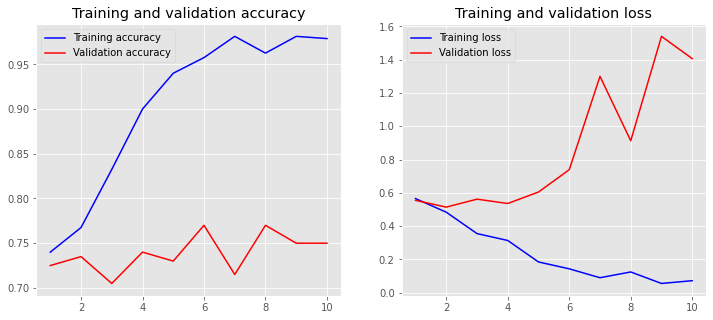

In [37]:
plot_history(history)